In [101]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor

In [87]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# read Covid-19 SG dataset
sg_data = pd.read_csv(url)
sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

In [44]:
sg_data_filtered.tail()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,Cumulative Deaths,Tested positive demise,Daily Imported,Daily Local transmission,Local cases residing in dorms MOH report,Local cases not residing in doms MOH report,Intensive Care Unit (ICU),General Wards MOH report,In Isolation MOH report,Total Completed Isolation MOH report,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
644,2021-10-28,3432,0.0,187851,4348,0,155950,29827,1702,15,364,0,9,3423,252.0,3171.0,61,1671.0,29827.0,145992.0,9936.0,430.0,NaN,NaN,Stabilisation Phase,10049015.0,4734669.0,4675888.0,85%,84%
645,2021-10-29,4248,0.0,192099,3011,0,158961,31166,1584,16,380,0,2,4246,536.0,3710.0,59,1555.0,31166.0,148921.0,10018.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
646,2021-10-30,3112,0.0,195211,3912,0,162873,30339,1597,14,394,0,4,3108,500.0,2608.0,60,1567.0,30339.0,152479.0,10372.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
647,2021-10-31,3163,0.0,198374,3759,0,166632,29685,1642,13,407,0,4,3159,414.0,2745.0,61,1611.0,29685.0,156104.0,10506.0,414.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
648,2021-11-01,2470,0.0,200844,3552,0,170184,28544,1687,14,421,0,3,2467,278.0,2189.0,62,1655.0,28544.0,159543.0,10619.0,417.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%


In [45]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          649 non-null    object 
 1   Daily Confirmed                               649 non-null    int64  
 2   False Positives Found                         540 non-null    float64
 3   Cumulative Confirmed                          649 non-null    int64  
 4   Daily Discharged                              649 non-null    int64  
 5   Passed but not due to COVID                   649 non-null    int64  
 6   Cumulative Discharged                         649 non-null    int64  
 7   Discharged to Isolation                       649 non-null    int64  
 8   Still Hospitalised                            649 non-null    int64  
 9   Daily Deaths                                  649 non-null    int

In [46]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [47]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [48]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [49]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [50]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [51]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [52]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               649 non-null    int64  
 1   False Positives Found                         649 non-null    float64
 2   Cumulative Confirmed                          649 non-null    int64  
 3   Daily Discharged                              649 non-null    int64  
 4   Passed but not due to COVID                   649 non-null    int64  
 5   Cumulative Discharged                         649 non-null    int64  
 6   Discharged to Isolation                       649 non-null    int64  
 7   Still Hospitalised                            649 non-null    int64  
 8   Daily Deaths                                  649 non-null    int64  
 9   Cumulative Deaths                             649 non-null    int

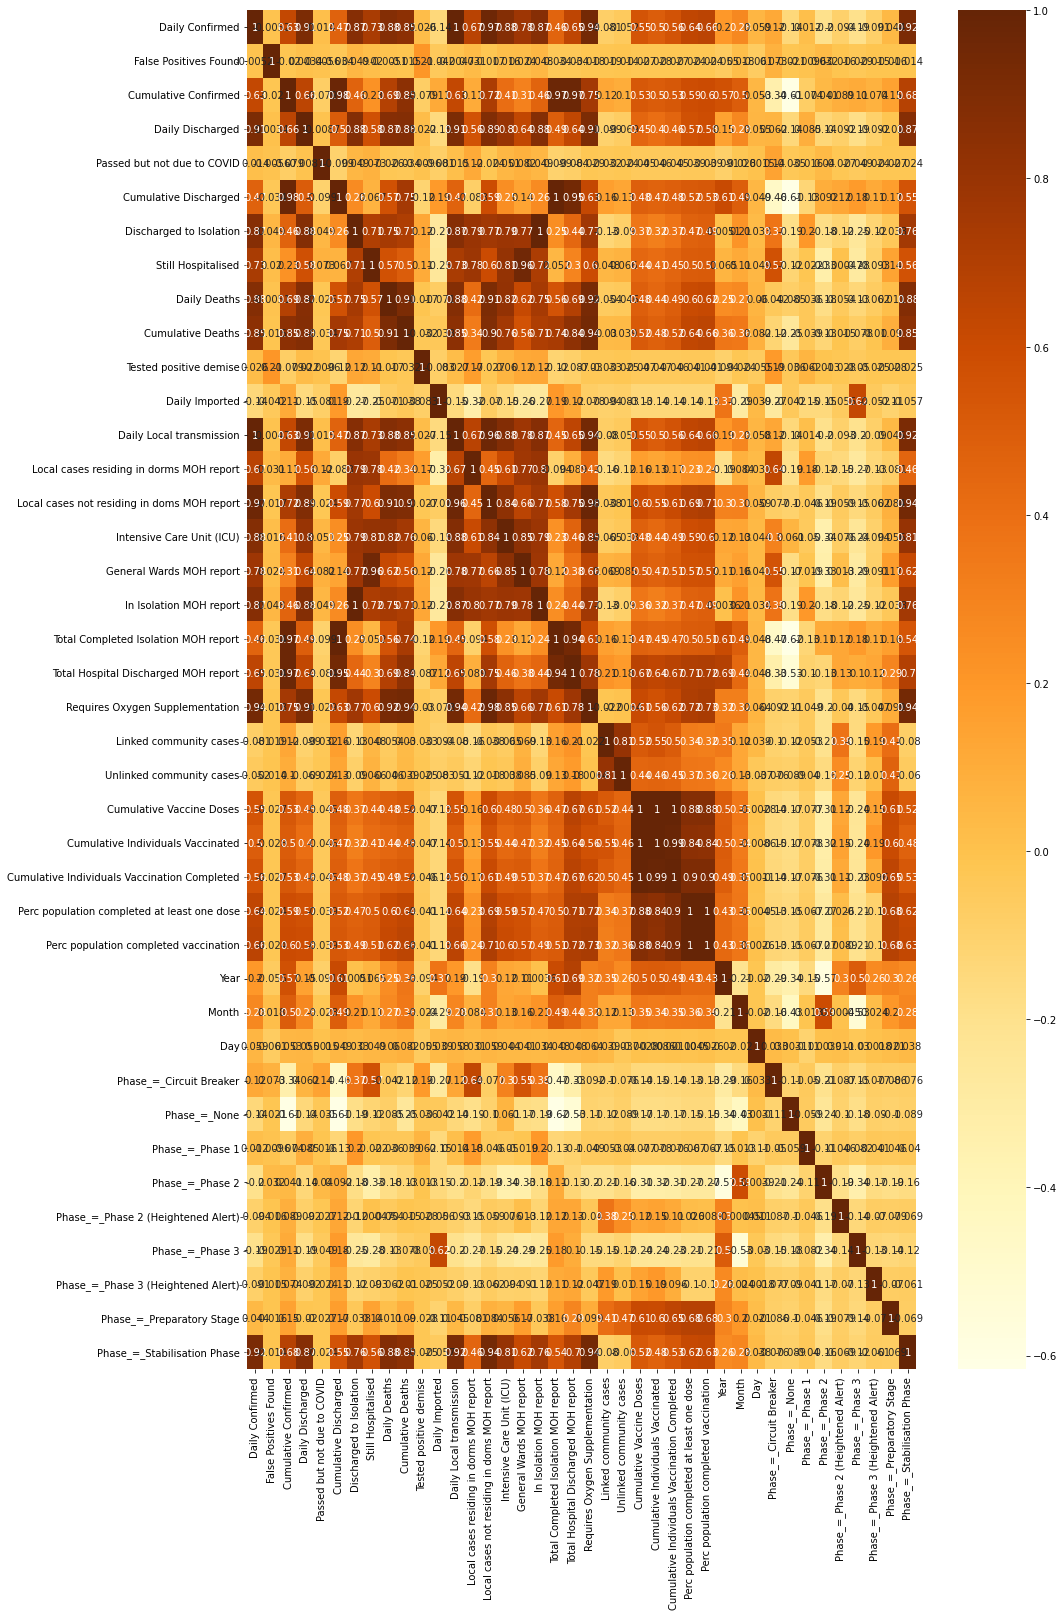

In [53]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [54]:
sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.977416
Phase_=_Stabilisation Phase                     0.939436
Daily Confirmed                                 0.938118
Cumulative Deaths                               0.937971
Daily Local transmission                        0.937386
Daily Deaths                                    0.924773
Daily Discharged                                0.907140
Intensive Care Unit (ICU)                       0.848458
Total Hospital Discharged MOH report            0.778063
Discharged to Isolation                         0.766563
In Isolation MOH report                         0.765676
Cumulative Confirmed                            0.749090
Perc population completed vaccination           0.732371
Perc population completed at least one dose     0.715798
General Wards MOH report                        0.660144
Cumulative Discharged                           0.626474
Cumulative Individuals Vaccinat

# Viewing Chart Pattern

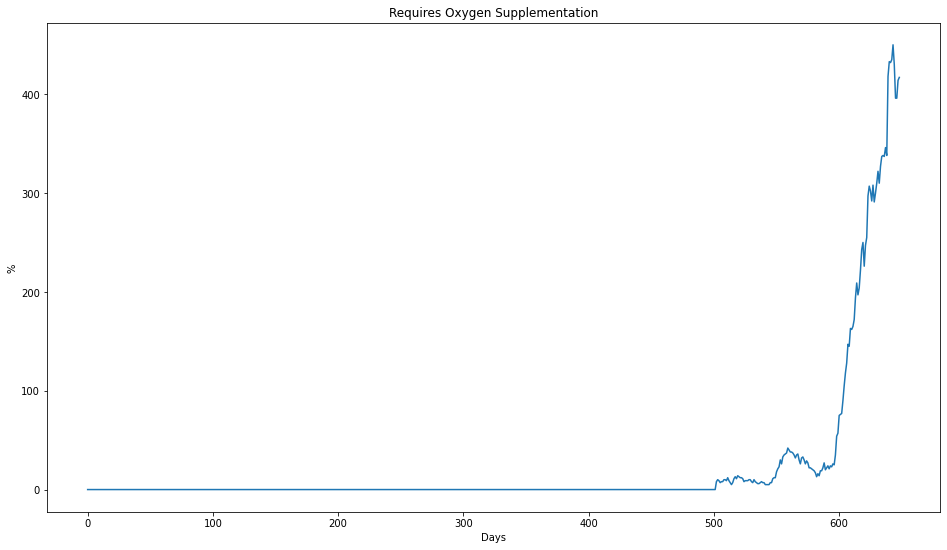

In [55]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Requires Oxygen Supplementation"].plot()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

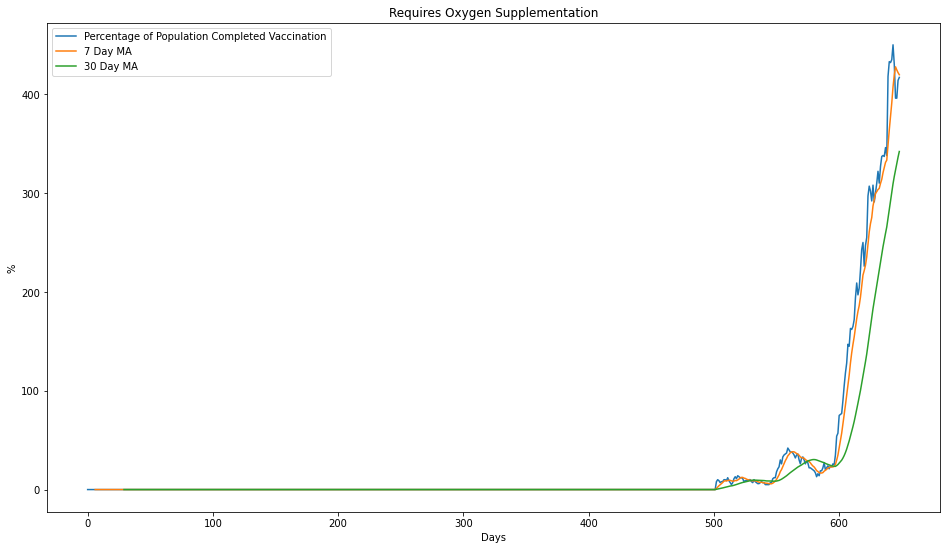

In [56]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

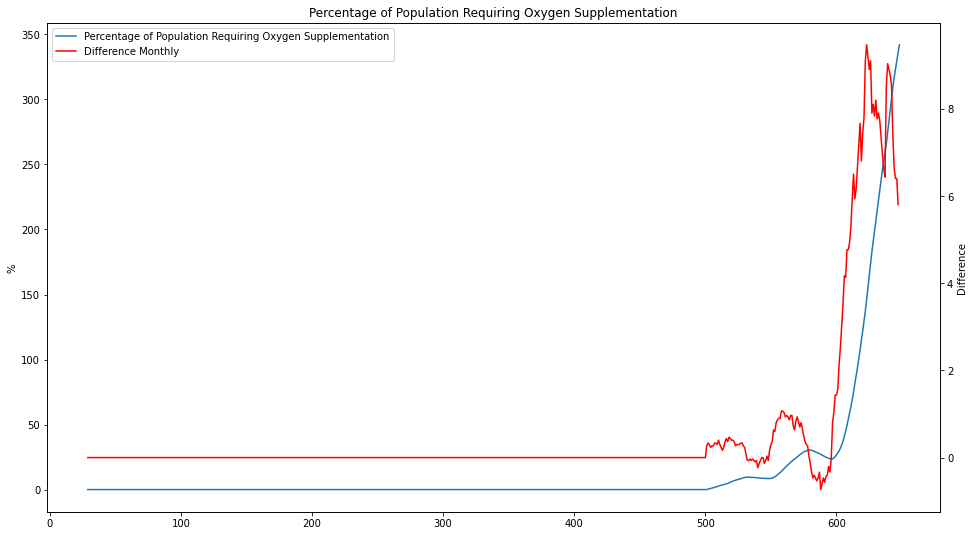

In [57]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="Percentage of Population Requiring Oxygen Supplementation")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Requiring Oxygen Supplementation')
plt.xlabel('Days')
plt.show()

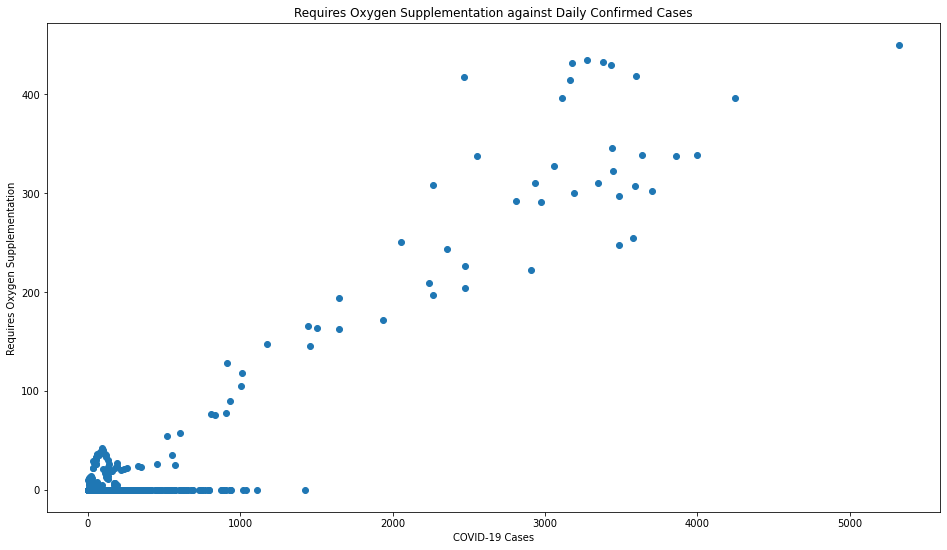

In [58]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Requires Oxygen Supplementation"])
plt.title('Requires Oxygen Supplementation against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('Requires Oxygen Supplementation')
plt.show()

# Train Test Split & KFold Cross Validation

In [59]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [60]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [61]:
# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear regression

In [62]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [63]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 4.67433869685315
MSE: 57.95403210415934
RMSE: 7.612754567445304
R-squared score for train: 0.9932340048719918
Adjusted R-squared score for train: 0.9928007145435972
R-squared score for test: 0.9912429282208595
Adjusted R-squared score for test: 0.9906821305207174
Cross Validation Score: 0.9912


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


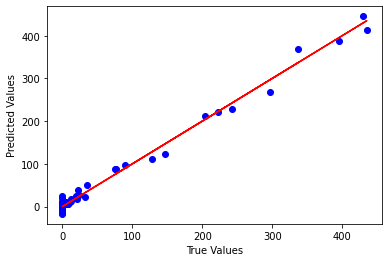

In [64]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

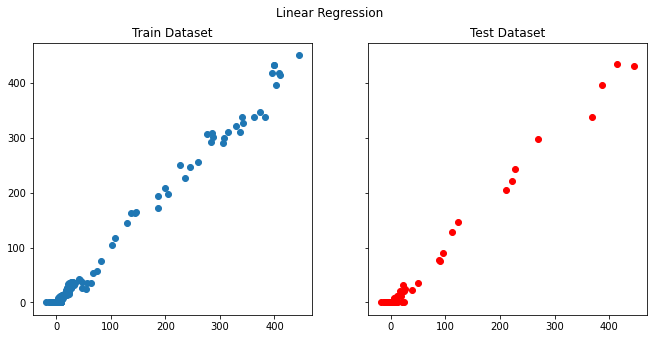

In [65]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [66]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.029690e+08
25,Perc population completed at least one dose,6.405778e+02
38,Phase_=_Stabilisation Phase,2.719629e+01
31,Phase_=_None,1.821679e+01
7,Still Hospitalised,5.248301e+00
6,Discharged to Isolation,5.246736e+00
5,Cumulative Discharged,5.059395e+00
9,Cumulative Deaths,5.014376e+00
10,Tested positive demise,3.386640e+00
37,Phase_=_Preparatory Stage,2.144783e+00


# Lasso Regression

In [67]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27187.92634105058, tolerance: 296.0248073217726
  positive)


In [68]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(lasso, X, y, cv=strat_k_fold)), 4)}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Evaluation Metrics for Lasso
MAE: 5.843469863475862
MSE: 114.58357734544806
RMSE: 10.704371880005294
R-squared score for train: 0.9825687012105582
Adjusted R-squared score for train: 0.9814524111402984
R-squared score for test: 0.9826859913781086
Adjusted R-squared score for test: 0.9815772125008446


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28982.85673003667, tolerance: 309.6722046242775
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26698.4158549751, tolerance: 308.8194073217726
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25443.5457033607, tolerance: 303.97309518304434
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25800.9067514

Cross Validation Score: 0.9797


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26300.724986107598, tolerance: 307.4982444230769
  positive)


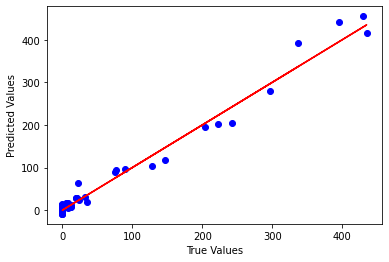

In [69]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

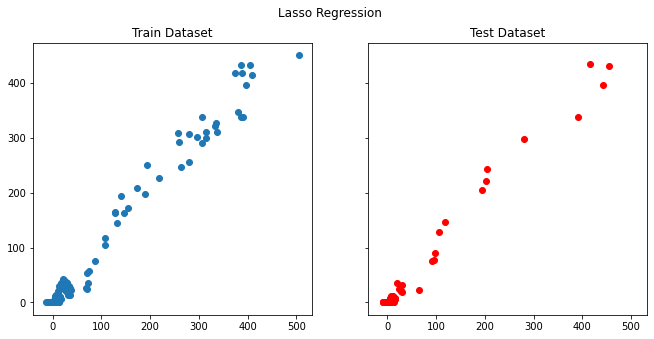

In [70]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [71]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
8,Daily Deaths,1.092037
9,Cumulative Deaths,0.492220
15,Intensive Care Unit (ICU),0.473172
0,Daily Confirmed,0.080248
29,Day,0.018411
3,Daily Discharged,0.009398
7,Still Hospitalised,0.008113
19,Total Hospital Discharged MOH report,0.004711
6,Discharged to Isolation,0.003120
2,Cumulative Confirmed,0.000560


In [72]:
## Ridge Regression

In [77]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 4.67433869685315
MSE: 57.95403210415934
RMSE: 7.612754567445304
R-squared score for train: 0.9932340048719918
Adjusted R-squared score for train: 0.9928007145435972
R-squared score for test: 0.9912429282208595
Adjusted R-squared score for test: 0.9906821305207174
Cross Validation Score: 0.9912


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


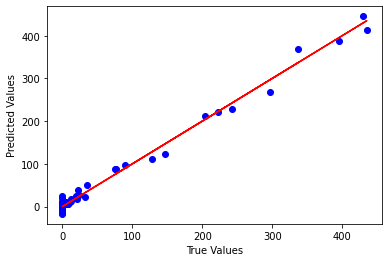

In [78]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

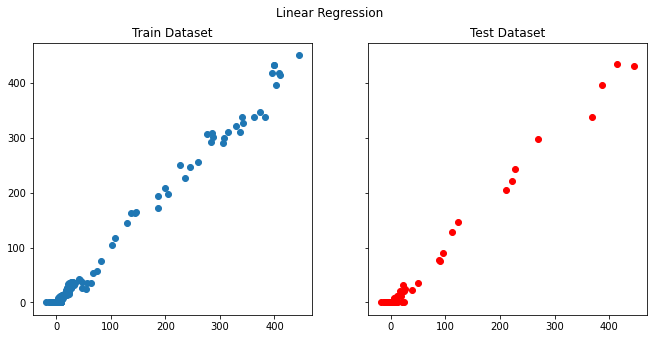

In [80]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [81]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.029690e+08
25,Perc population completed at least one dose,6.405778e+02
38,Phase_=_Stabilisation Phase,2.719629e+01
31,Phase_=_None,1.821679e+01
7,Still Hospitalised,5.248301e+00
6,Discharged to Isolation,5.246736e+00
5,Cumulative Discharged,5.059395e+00
9,Cumulative Deaths,5.014376e+00
10,Tested positive demise,3.386640e+00
37,Phase_=_Preparatory Stage,2.144783e+00


# Ridge Regression

In [84]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.48296e-17): result may not be accurate.
  overwrite_a=True).T


In [88]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 4.784730187259042
MSE: 69.36279796259372
RMSE: 8.328433103687255
R-squared score for train: 0.9910035123372644
Adjusted R-squared score for train: 0.9904273825854636
R-squared score for test: 0.9895190208772918
Adjusted R-squared score for test: 0.9888478251699263
Cross Validation Score: 0.9888


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.48296e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.26061e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.71314e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.32161e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.00023e-17): result may not be accurate.
  overwrite_a=True).T


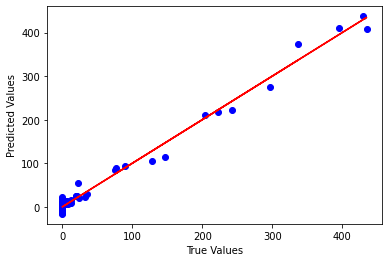

In [89]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

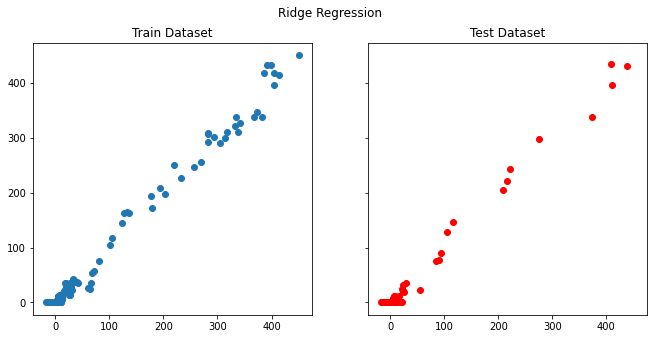

In [90]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [91]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
31,Phase_=_None,20.495533
38,Phase_=_Stabilisation Phase,8.803746
25,Perc population completed at least one dose,6.311461
7,Still Hospitalised,5.625463
6,Discharged to Isolation,5.622581
9,Cumulative Deaths,5.529239
5,Cumulative Discharged,5.466727
33,Phase_=_Phase 2,3.147327
10,Tested positive demise,1.939983
34,Phase_=_Phase 2 (Heightened Alert),1.447478


# Ridge regression important features & future prediction

In [93]:
# taking out the important features based on the importance level mentioned above as well as necessary features (e.g. Year Day Month)
# add in all the phases
important_X = X[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [94]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [95]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 7.809522010665611
MSE: 239.4755046231366
RMSE: 15.474996110601664
R-squared score for train: 0.9791551472678645
Adjusted R-squared score for train: 0.9785595800469463
R-squared score for test: 0.9638143523894658
Adjusted R-squared score for test: 0.9627804767434505
Cross Validation Score: 0.9727


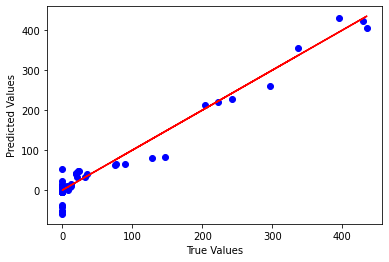

In [96]:
# For test set

# scatter for predictions
plt.scatter(y_test, impt_ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

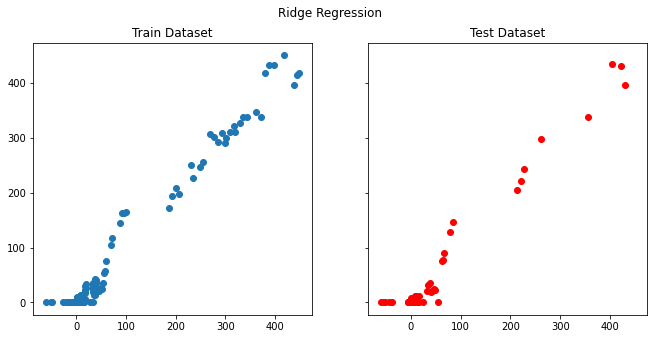

In [97]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(impt_ridge.predict(important_X_train), y_train)
ax[1].scatter(impt_ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

#XGBoost

In [102]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=5)
xgb_search.fit(important_X, y)
xgb_search.best_params_

[07:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.9,
 'max_depth': 10,
 'min_child_weight': 6,
 'subsample': 0.8}

In [103]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=4, colsample_bytree=0.7, min_child_weight=4)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Evaluation Metrics for XGBoost
MAE: 1.1385433586744163
MSE: 17.521148548399648
RMSE: 4.185827104456137
R-squared score for train: 0.9997297870663838
Adjusted R-squared score for train: 0.9997220666968519
R-squared score for test: 0.9973524886893882
Adjusted R-squared score for test: 0.997276845509085
[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:40:16] WARNING: /workspace/src/objective/regression_obj.cu:

# Prediction with XGBoost

In [105]:

future_prediction = pd.DataFrame(data={
    "Perc population completed at least one dose":[90],
    "Tested positive demise":[0],
    "Cumulative Deaths":[600],
    "Discharged to Isolation":[45000],
    "Still Hospitalised":[1800],
    "Cumulative Discharged":[250000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)

In [107]:
xgb_fut_pred

array([429.27786], dtype=float32)